# Temporal CNN with uncertainty

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.metrics as metrics
from deep4cast import custom_losses

%matplotlib inline

Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
df = pd.read_table('sp500.csv', sep=',')
df = df.replace(-1,np.nan)
df = df.replace("#DIV/0!",np.nan)
df = df.dropna()
df.Date = pd.to_datetime(df.Date)
df['Closing Value'] = pd.to_numeric(df['Closing Value'])
df.Return = pd.to_numeric(df.Return)
df.set_index('Date', inplace=True)

time = df.index
data = df['Return'].values
data = np.expand_dims(data,0)
data = np.expand_dims(data,2)

train_length = int(data.shape[1]*0.75)
train_data = data[:,:train_length,:]

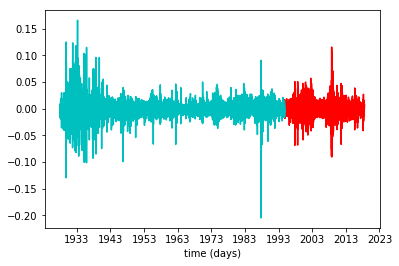

In [3]:
# Let plot the data
plt.plot(time[train_length:], data[0,train_length:,0], 'r-')
plt.plot(time[:train_length], data[0,:train_length,0], 'c-')
plt.xlabel('time (days)')
plt.show()

## Topology for CNN

Here, we are simply stacking a few convolutional layers on top of each other to build a deep architecture. 

In [55]:
topology = [
        {
            'meta': {
                'layer_type': 'Conv1D',
                'layer_id': 'conv1',
                'parent_ids': ['input']
            },
            'params': {
                'filters': 128,
                'kernel_size': 2,
                'dilation_rate': 1,
                'padding': 'causal',
                'use_bias': True,
                'activation': 'relu'
            }
        },
        {
            'meta': {
                'layer_type': 'Conv1D',
                'layer_id': 'conv2',
                'parent_ids': ['conv1']
            },
            'params': {
                'filters': 64,
                'kernel_size': 2,
                'dilation_rate': 2,
                'padding': 'causal',
                'use_bias': True,
                'activation': 'relu'
            }
        },
        {
            'meta': {
                'layer_type': 'Flatten',
                'layer_id': 'flat1',
                'parent_ids': ['conv2']
            },
            'params': {}
        }
    ]

Let's fit the forecaster!

In [71]:
forecaster = Forecaster(
    topology,
    lag=10,  # This is the number of time steps used to predict the future for each data point
    horizon=1,  # This is how many time steps into the future we want to produce
    optimizer='nadam',  # Which optimizer the forecaster is using
    loss=custom_losses.heteroscedastic_t(nu=5,n_dim=1), 
    dropout_rate=0.1,
    lr=0.001,  # This is the learning rate for the optimizer
    max_epochs=10  # Maximum number of epochs that the optimizer will perform
)

The target variable here denotes the index of the target time series, we are trying to forecast.

In [72]:
forecaster.fit(train_data, patience=3, verbose=2)  # patience is the number of epochs to wait until early stopping is executed

Train on 16050 samples, validate on 1783 samples
Epoch 1/10
 - 14s - loss: 0.3151 - val_loss: 0.3502
Epoch 2/10
 - 13s - loss: 0.2574 - val_loss: 0.3338
Epoch 3/10
 - 12s - loss: 0.2438 - val_loss: 0.3201
Epoch 4/10
 - 13s - loss: 0.2428 - val_loss: 0.3104
Epoch 5/10
 - 13s - loss: 0.2320 - val_loss: 0.2946
Epoch 6/10
 - 13s - loss: 0.2251 - val_loss: 0.3011
Epoch 7/10
 - 13s - loss: 0.2258 - val_loss: 0.3139
Epoch 8/10
 - 13s - loss: 0.2249 - val_loss: 0.2879
Epoch 9/10
 - 13s - loss: 0.2198 - val_loss: 0.2996
Epoch 10/10
 - 13s - loss: 0.2157 - val_loss: 0.3019


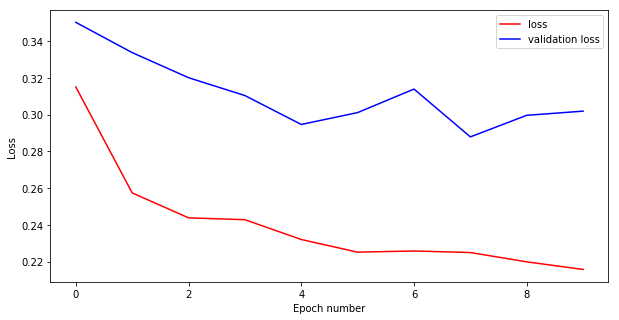

In [74]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

Let's look at the data from the financial crisis

In [75]:
horizon = 40
n_samples = 25
test_time = time[train_length-horizon:]
test_data = data[:,train_length-horizon:,:]
X, __ = forecaster._sequentialize(test_data)
pred_mean, pred_std, pred_lq, pred_uq = [], [], [], []
for i, step in enumerate(X):
    if i%2000 == 0:
        print(i)
    step = np.expand_dims(step, 0)
    prediction = forecaster.predict(step, n_samples=n_samples)
    pred_mean.append(prediction['mean'])
    pred_std.append(prediction['std'])
    pred_lq.append(prediction['lower_quantile'])
    pred_uq.append(prediction['upper_quantile'])
pred_mean = np.squeeze(np.array(pred_mean))
pred_std = np.squeeze(np.array(pred_std))
pred_lq = np.squeeze(np.array(pred_lq))
pred_uq = np.squeeze(np.array(pred_uq))
actual_data = np.squeeze(data[:,train_length-1:,:])[:len(pred_lq)]
test_time = time[train_length-1:][:len(pred_lq)]

0
2000
4000


In [63]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [64]:
std = np.std(rolling_window(actual_data, 3), 1)
std = np.hstack([np.array([1]*6)*np.nan, std])

ValueError: x and y must have same first dimension, but have shapes (5949,) and (5984,)

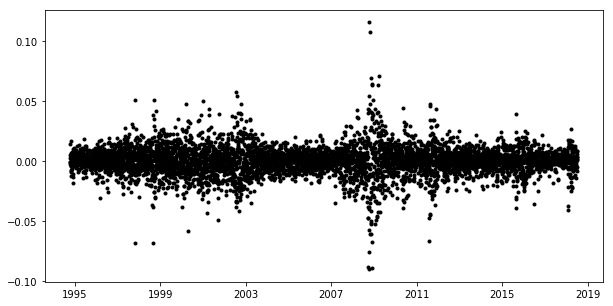

In [65]:
plt.figure(figsize=(10,5))
plt.plot(test_time, actual_data, 'k.')
plt.plot(test_time, pred_lq, 'c')
plt.plot(test_time, pred_uq, 'c')

(0, 0.1774013513633265)

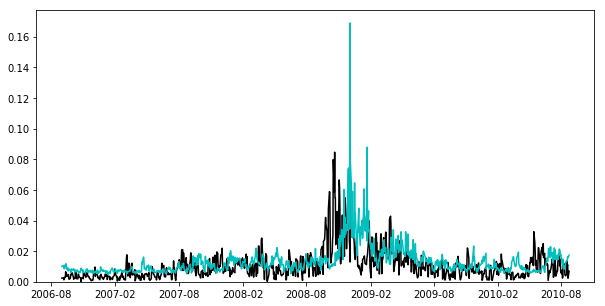

In [66]:
plt.figure(figsize=(10,5))
rng = np.arange(3000,4000)
plt.plot(test_time[rng], std[rng], 'k-')
plt.plot(test_time[rng], pred_std[rng], 'c')
plt.ylim([0, None])

In [67]:
np.mean(actual_data > pred_uq), np.mean(actual_data < pred_lq)

ValueError: operands could not be broadcast together with shapes (5949,) (5984,) 

In [68]:
np.mean(np.abs((pred_std[rng]-std[rng])))

0.007087208574986932

In [69]:
np.mean(np.abs((std[rng][:-1]-std[rng][1:])))

0.003720845066904228